## Analysis of Translation Efficiencies

### 1 Data import

In [1]:
import cPickle as pkl
import collections as col
import pandas as pd
import numpy as np
import matplotlib

matplotlib.use("pgf")
pgf_with_rc_fonts = {
    "font.family": "serif",
    "font.serif": [u'Adobe Caslon Pro'],                   # use latex default serif font
    "font.sans-serif": ["Consolas"], # use a specific sans-serif font
}
matplotlib.rcParams.update(pgf_with_rc_fonts)

import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.style.use('ggplot')
matplotlib.style.use('bmh')
from statsmodels.nonparametric.smoothers_lowess import lowess

To update the TEs, run https://github.com/gittenberg/TRSL/blob/master/workbooks/analyses/06%20TRSL_time-resolved_single-gene_analyses.ipynb first.

In [2]:
time_tes = pkl.load(open("../../parameters/te_time-resolved.p"))
init_rates = pkl.load(open("../../parameters/init_rates_plotkin.p"))

In [3]:
annotations = pd.DataFrame.from_csv('../../data/sce_Nagaraj.tsv', sep='\t', header=1)

How many can we work with:

In [4]:
print time_tes.shape
print len(init_rates.keys())
print len(annotations.index)
print len(time_tes.transpose().to_dict().viewkeys() & init_rates.viewkeys())

(5581, 12)
4839
3794
4606


### 2 Translation efficiencies vs initiation rates over the cycle

In [5]:
def scatter_dicts(dict1, dict2, lowess=True, logaxis=True, xaxislabel=None, yaxislabel=None, fontsize=None, alpha=0.2):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    if logaxis:
        ax.set_xscale('log')
        ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
    if fontsize:
        plt.setp(ax.get_xticklabels(), fontsize=fontsize)
        plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(alpha)

    if lowess:
        points = zip(xs, ys)
        sorted_points = sorted(points)
        new_xs = [point[0] for point in sorted_points]
        new_ys = [point[1] for point in sorted_points]
        ylowess = lowess(new_ys, new_xs)[:,1]
        plt.plot(new_xs, ylowess, 'orange', linewidth=4)

In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

4606


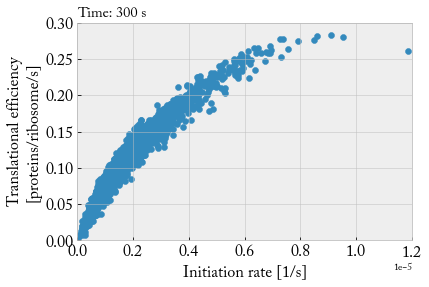

4606


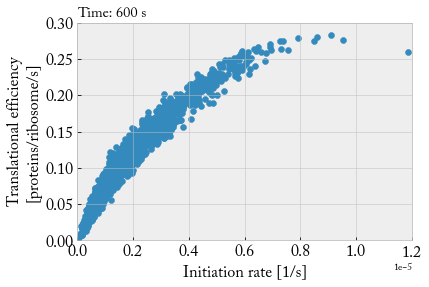

4606


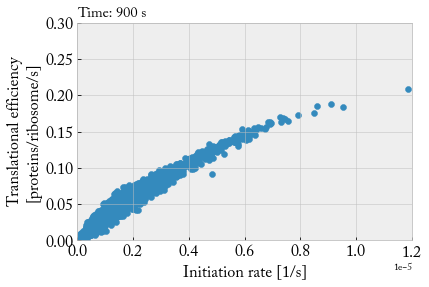

4606


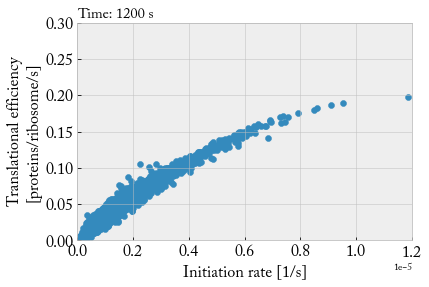

4606


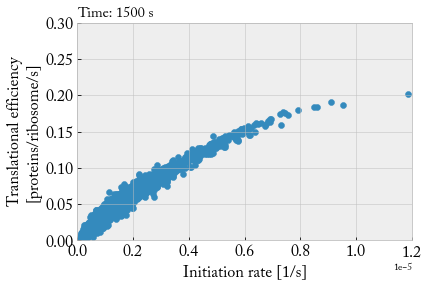

4606


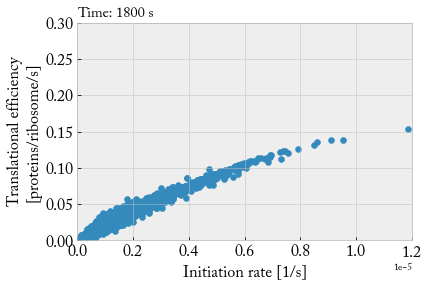

4606


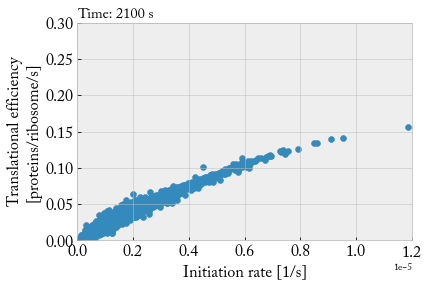

4606


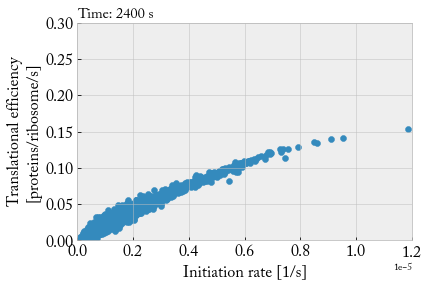

4606


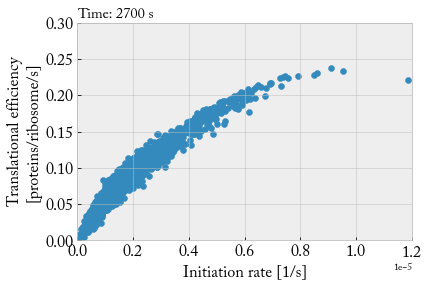

4606


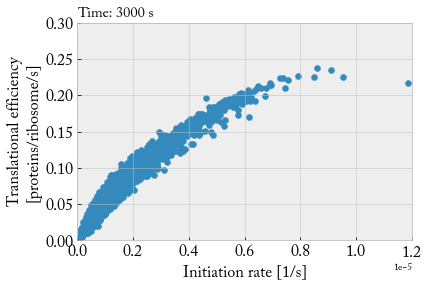

4606


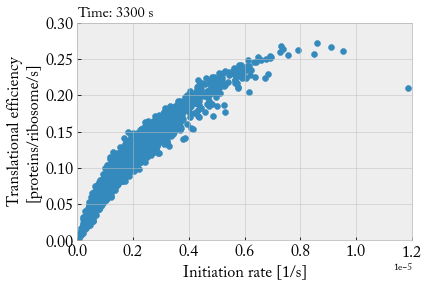

4606


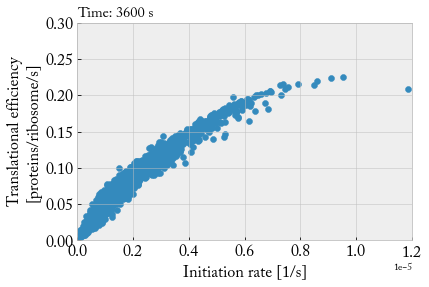

In [7]:
for time in time_tes.columns:
    scatter_dicts(init_rates, time_tes[time].to_dict(), logaxis=False, lowess=False, xaxislabel='Initiation rate [1/s]', 
                  yaxislabel='Translational efficiency\n[proteins/ribosome/s]', fontsize=16, alpha=1.0)
    plt.title('Time: {} s'.format(time+300), loc='left')
    plt.xlim([1e-8, 1.2e-5])
    plt.ylim([0.0, 0.3])
    plt.locator_params(axis='x',nbins=10)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.show()

### 3 Same but with annotation and color

In [8]:
all_annotations = pkl.load(open("../../parameters/annotations_liebermeister.p", "rb"))
annotations = {k: v for k, v in all_annotations.items() if v}  # remove empty values
all_functional_categories = col.Counter(annotations.values())
functional_categories = col.Counter({k: v for k, v in all_functional_categories.items() if v >= 50}) # minimum count
annotations = {k: v for k, v in annotations.items() if v in functional_categories}

Comparing all annotations with those that have the minimum count:

In [9]:
# intersection
anno_keys = init_rates.viewkeys() & time_tes.transpose().to_dict().viewkeys() & all_annotations.viewkeys()
print len(anno_keys)

3467


In [10]:
plotkeys = init_rates.viewkeys() & time_tes.transpose().to_dict().viewkeys() & annotations.viewkeys() # intersection
print len(plotkeys)

724


In [11]:
import matplotlib.cm as cm
colormap = cm.Set1(np.linspace(0, 1, len(functional_categories.most_common())))
colordict = {j[0]: colormap[i] for i, j in enumerate(functional_categories.most_common())}

In [12]:
colors = [colordict[annotations[key]] for key in plotkeys]

We create several series and scatter on top of each other.

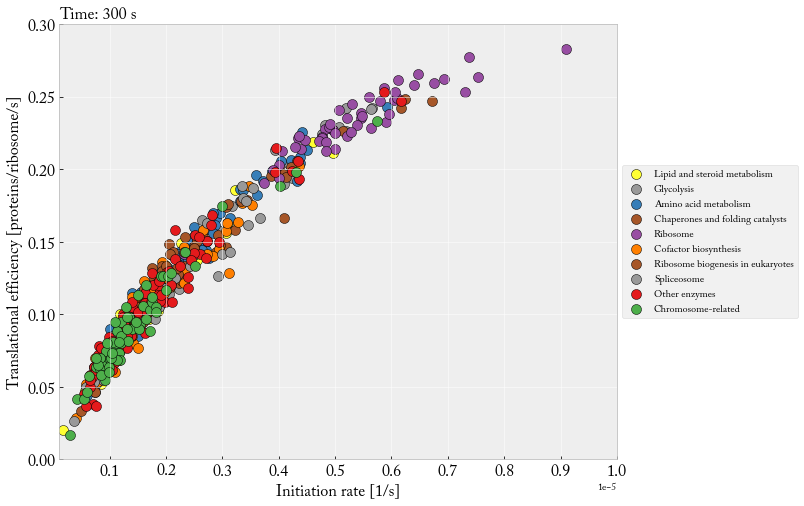

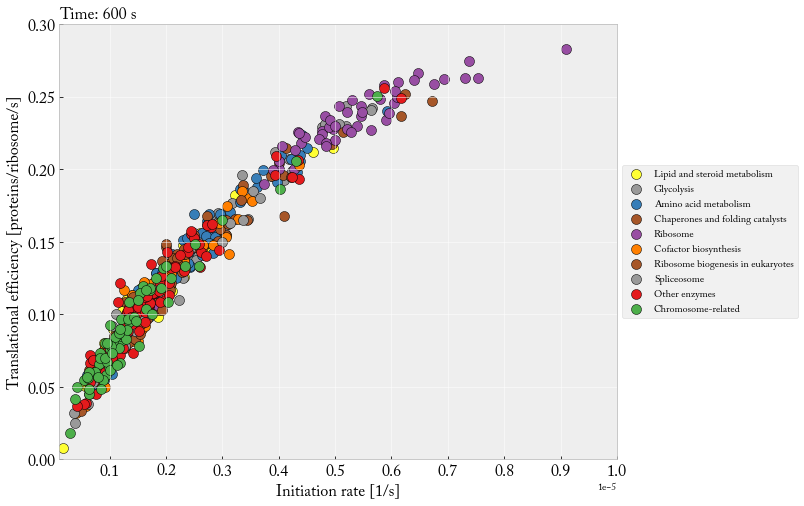

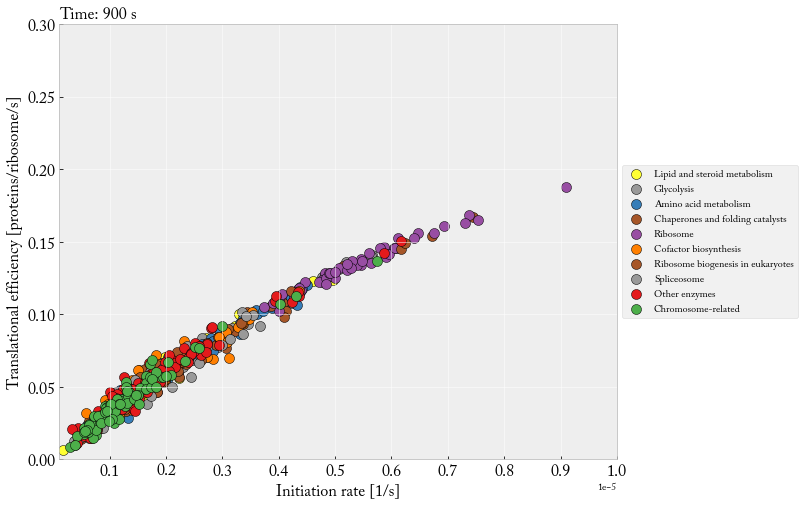

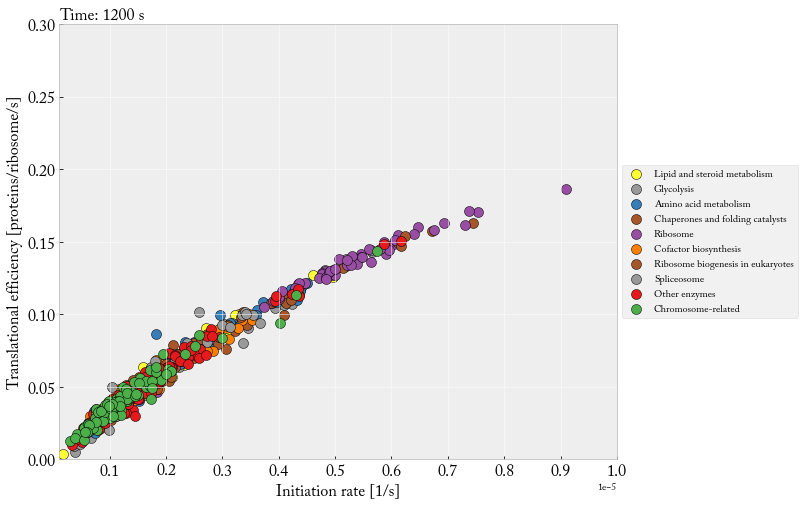

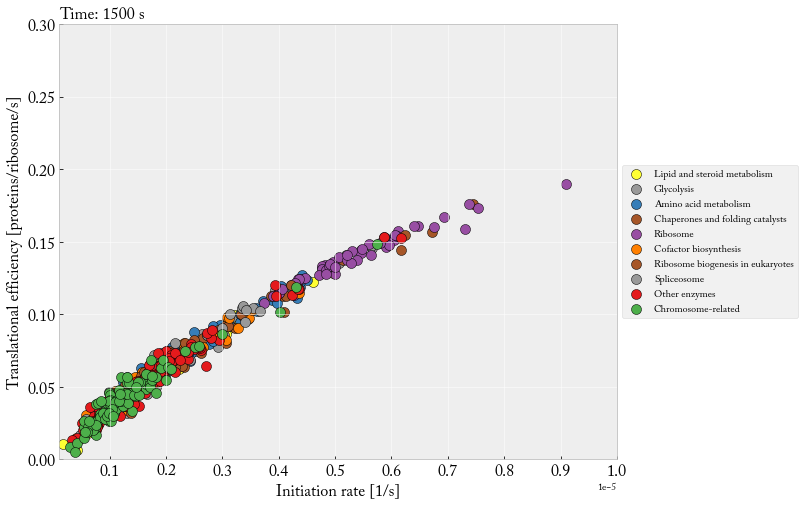

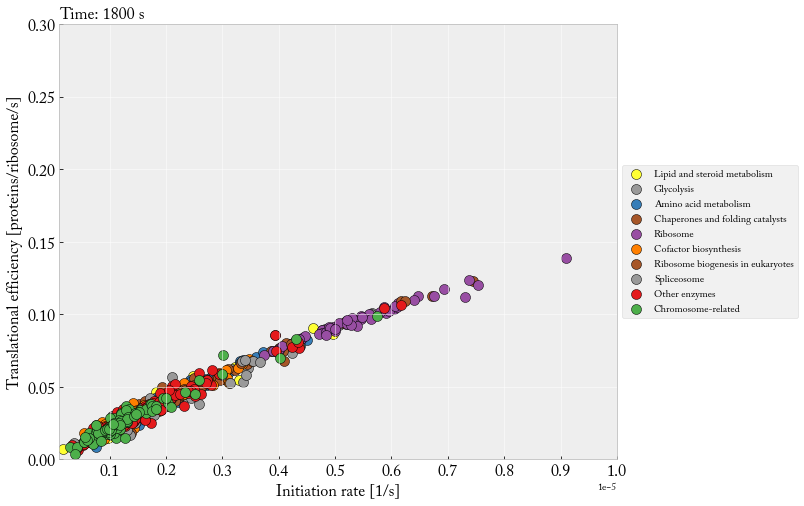

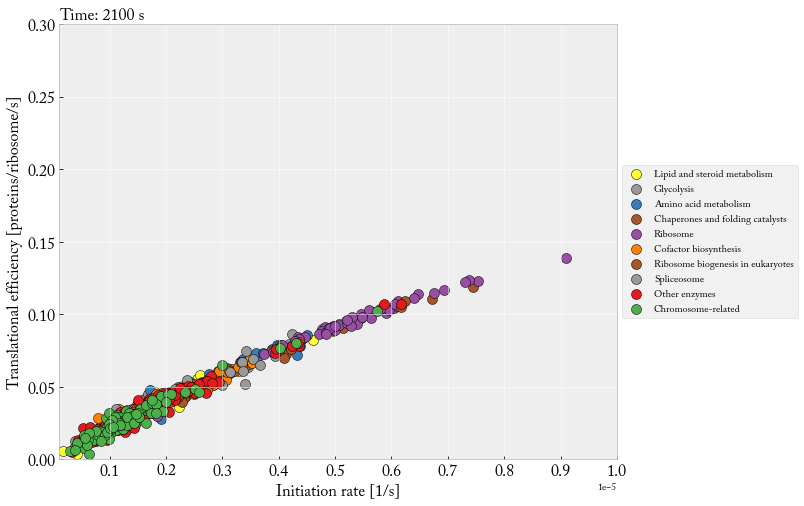

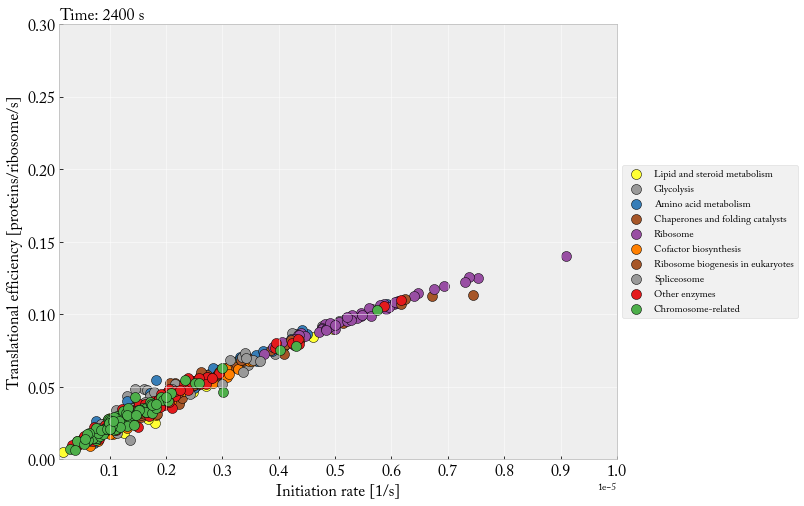

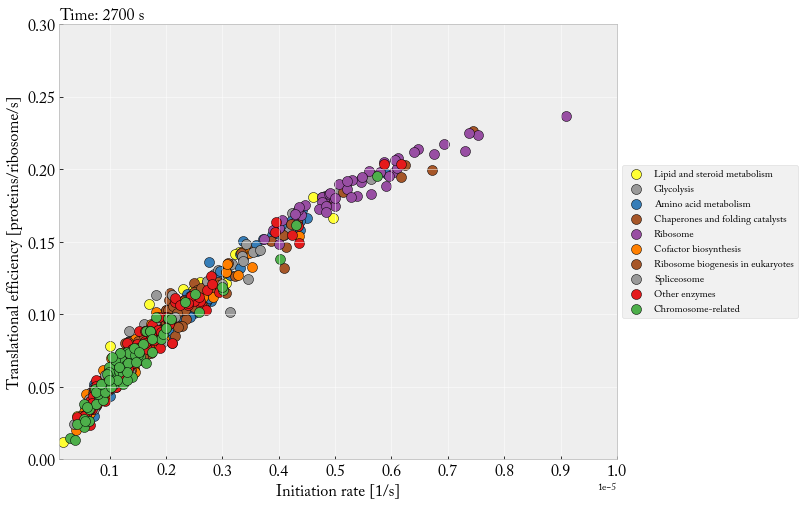

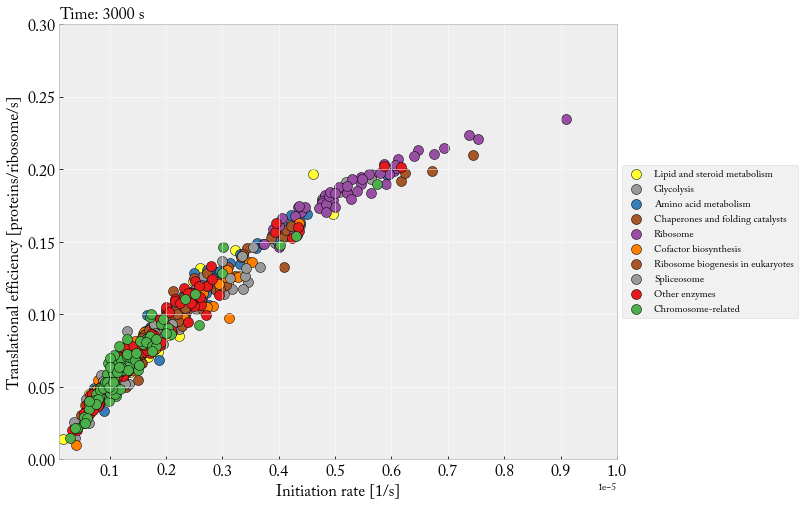

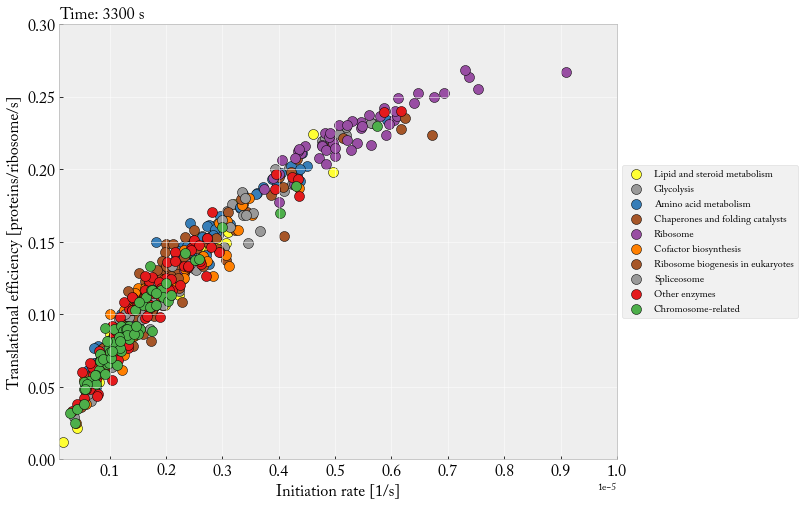

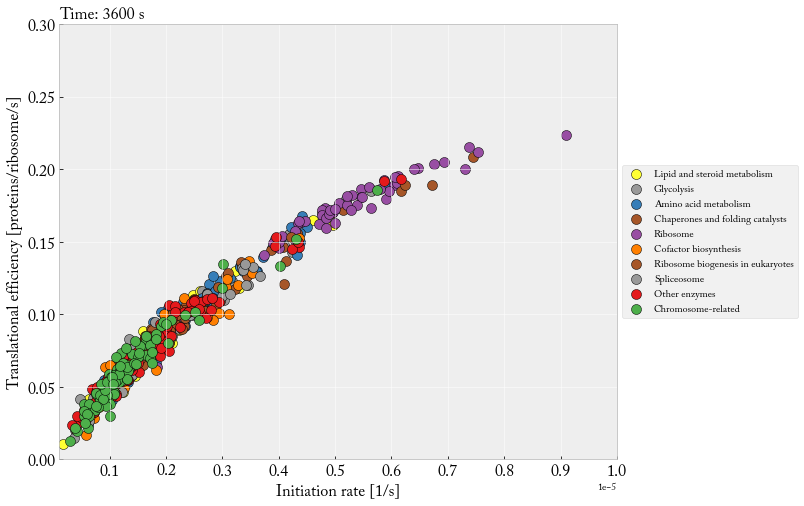

In [14]:
time_tes_by_function = {}
init_rates_by_function = {}

for time in time_tes.columns:
    time_tes_by_function[time] = {}

    for function in functional_categories.keys():
        init_rates_by_function[function] = [init_rates[key] for key in plotkeys if annotations[key]==function]
        time_tes_by_function[time][function] = [time_tes[time].to_dict()[key] for key in plotkeys 
                                                if annotations[key]==function]
    fontsize = 16

    xaxislabel = 'Initiation rate [1/s]'
    yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '1.0')

    for function in functional_categories.keys():
        scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                           label=function, s=100, edgecolor='black')
        scat.set_alpha(1.0)

    plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
    plt.xlim([1e-7, 1.0e-5])
    plt.ylim([0.0, 0.3])
    plt.locator_params(axis='x',nbins=10)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)

    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlabel(xaxislabel)
    ax.set_xlabel(xaxislabel, fontsize=fontsize)
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    ax.set_ylabel(yaxislabel)
    ax.set_ylabel(yaxislabel, fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

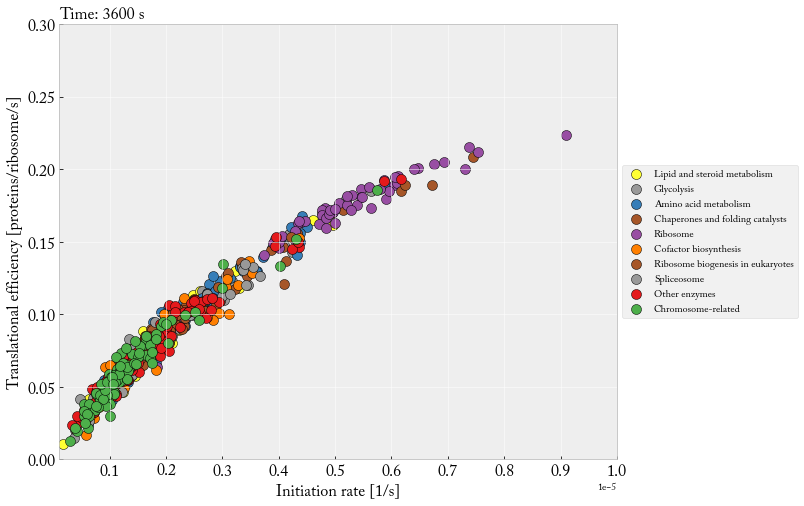

In [15]:
plt.rcParams['figure.figsize'] = (10, 8)

fontsize = 16
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

fig =  plt.figure()                

ax = fig.add_subplot(111)
ax.grid(True, linestyle = '-', color = '1.0')

for function in functional_categories.keys():
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                       label=function, s=100, edgecolor='black')
    scat.set_alpha(1.0)
    
plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)


### Plot against time axis

Let's do it right this time.

In [16]:
annotations_df = pd.DataFrame.from_dict(annotations, orient='index', dtype=None)
annotations_df.columns = ["Function"]

In [17]:
time_tes_annotated = pd.merge(time_tes, annotations_df, how='inner', on=None, left_on=None, right_on=None,
                              left_index=True, right_index=True, sort=True, copy=True, indicator=False)

In [18]:
time_tes_annotated.head()

,0,300,600,900,1200,1500,1800,2100,2400,2700,3000,3300,Function
YAL012W,0.213651,0.214825,0.120308,0.121721,0.123394,0.082078,0.085652,0.086278,0.166162,0.169553,0.202222,0.160543,Amino acid metabolism
YDR050C,0.242065,0.242206,0.140653,0.143106,0.145947,0.100717,0.101877,0.103427,0.196407,0.196591,0.232330,0.185873,Glycolysis
YMR288W,0.078333,0.100000,0.046667,0.030000,0.045000,0.019167,0.023000,0.034167,0.050000,NaN,0.085000,0.045000,Spliceosome
YLR197W,0.143333,0.145000,0.071322,0.069624,0.075333,0.048251,0.048145,0.050645,0.105000,0.108512,0.139792,0.102849,Ribosome biogenesis in eukaryotes
YBR167C,NaN,NaN,0.066667,0.063333,0.063333,0.040000,0.044167,0.052500,0.085000,0.103333,NaN,0.093333,Ribosome biogenesis in eukaryotes


In [19]:
print len(time_tes_annotated)
print len(time_tes)
print len(annotations_df)

831
5581
841


Same for the larger set:

In [20]:
all_annotations_df = pd.DataFrame.from_dict(all_annotations, orient='index', dtype=None)
all_annotations_df.columns = ["Function"]

In [21]:
all_time_tes_annotated = pd.merge(time_tes, all_annotations_df, how='inner', on=None, left_on=None, right_on=None,
                              left_index=True, right_index=True, sort=True, copy=True, indicator=False)

In [22]:
all_time_tes_annotated.head()

,0,300,600,900,1200,1500,1800,2100,2400,2700,3000,3300,Function
YBR177C,0.128333,0.133333,NaN,0.043333,0.055833,0.034167,0.031000,0.037500,0.091667,0.077500,0.123333,0.065000,
YIL140W,0.098333,0.100000,0.040833,0.048333,0.048333,0.031667,NaN,NaN,0.078333,NaN,NaN,NaN,
YLR268W,0.135000,0.110000,0.060333,0.054048,0.055333,0.036458,0.036970,0.034167,0.088333,0.080556,0.120000,0.072222,SNARE interactions in vesicular transport
YJL155C,0.115000,NaN,0.038333,0.053333,0.043333,0.035000,0.025833,0.020000,0.078333,0.080000,0.100000,0.075000,Carbohydrate metabolism
YLR197W,0.143333,0.145000,0.071322,0.069624,0.075333,0.048251,0.048145,0.050645,0.105000,0.108512,0.139792,0.102849,Ribosome biogenesis in eukaryotes


In [23]:
print len(all_time_tes_annotated)
print len(time_tes)
print len(all_annotations_df)

3727
5581
3794


http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

In [24]:
def rand_jitter(arr):
    stdev = .0125 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, 
           linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, 
                       vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)

/home/martin/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


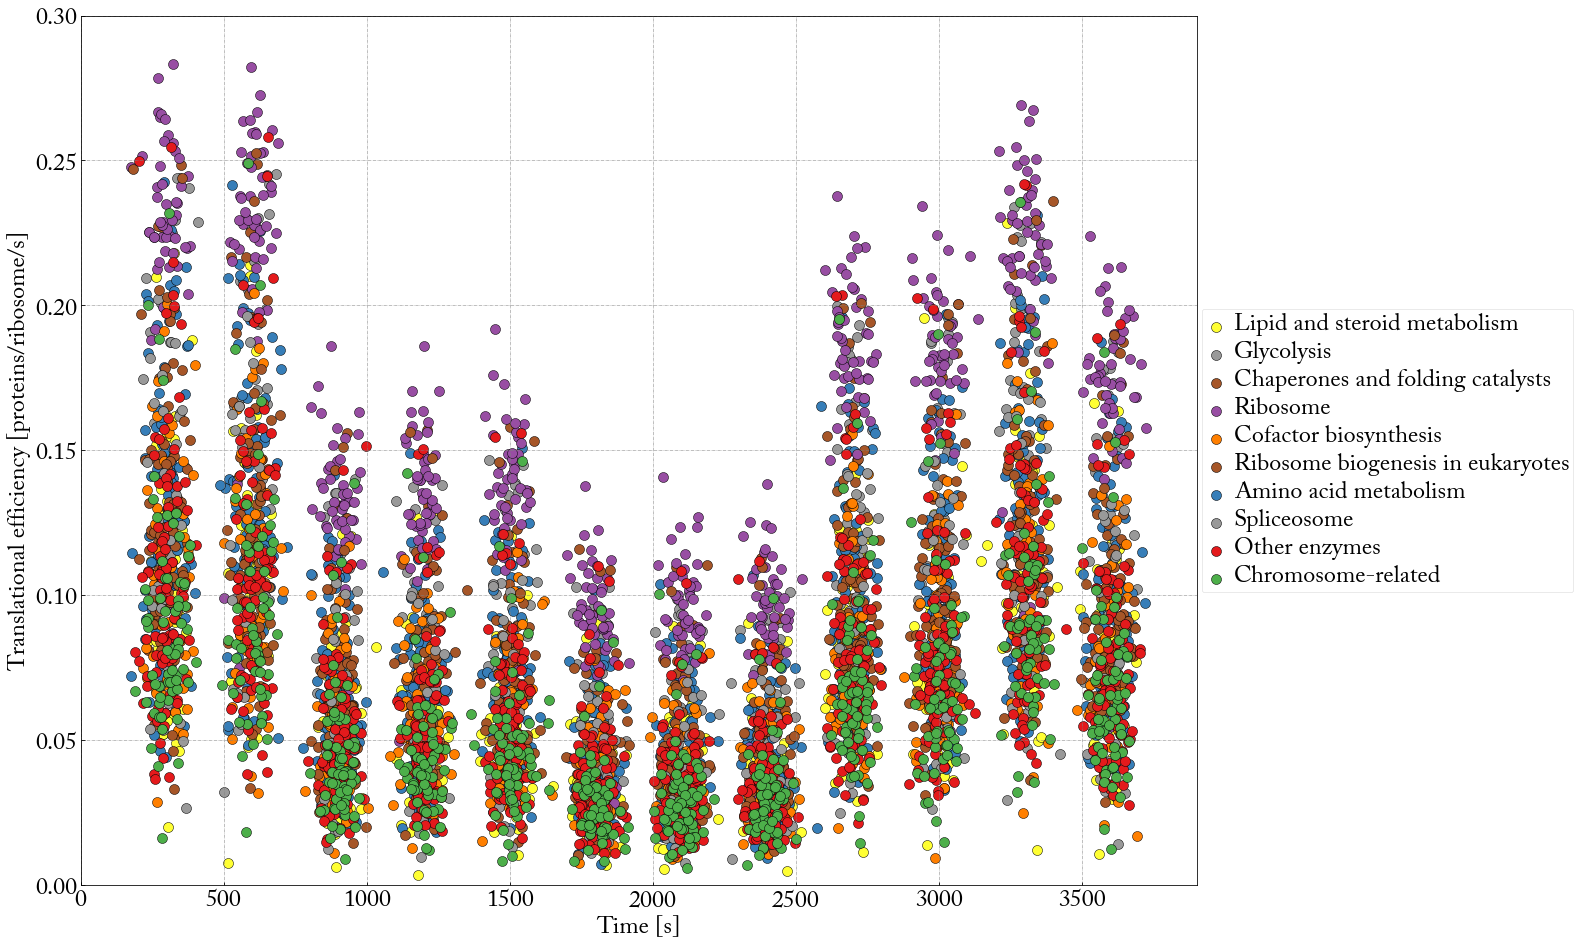

In [25]:
plt.rc('font',family=u'Adobe Caslon Pro')
plt.rcParams['figure.figsize'] = (20, 16)
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['axes.labelcolor']='black'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['grid.linestyle']='-.'
plt.rcParams['grid.color']='grey'
#plt.rcParams['figure.facecolor'] = 'white'

hfont = {'fontname': u'Adobe Caslon Pro'}

fig =  plt.figure()                

ax = fig.add_subplot(111, axisbg='white')

fontsize = 24

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency [proteins/ribosome/s]'

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlabel(xaxislabel, **hfont)
ax.set_xlabel(xaxislabel, fontsize=fontsize, **hfont)
plt.setp(ax.get_xticklabels(), fontsize=fontsize, **hfont)
#ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize, **hfont)
plt.setp(ax.get_yticklabels(), fontsize=fontsize, **hfont)

for function in functional_categories.keys():
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=100, edgecolor='black')
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

shortlabels = list(set(labels))

plt.legend(labels=shortlabels, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, facecolor="white")

legend = ax.get_legend()

for i, label in enumerate(shortlabels):
    legend.legendHandles[i].set_color(colordict[label])
    legend.legendHandles[i].set_edgecolor('black')

for label in legend.get_texts():
    label.set_fontsize(fontsize)
    
#plt.savefig("functional_time_resolved.png", bbox_inches='tight')
plt.show()

### Combined in one plot

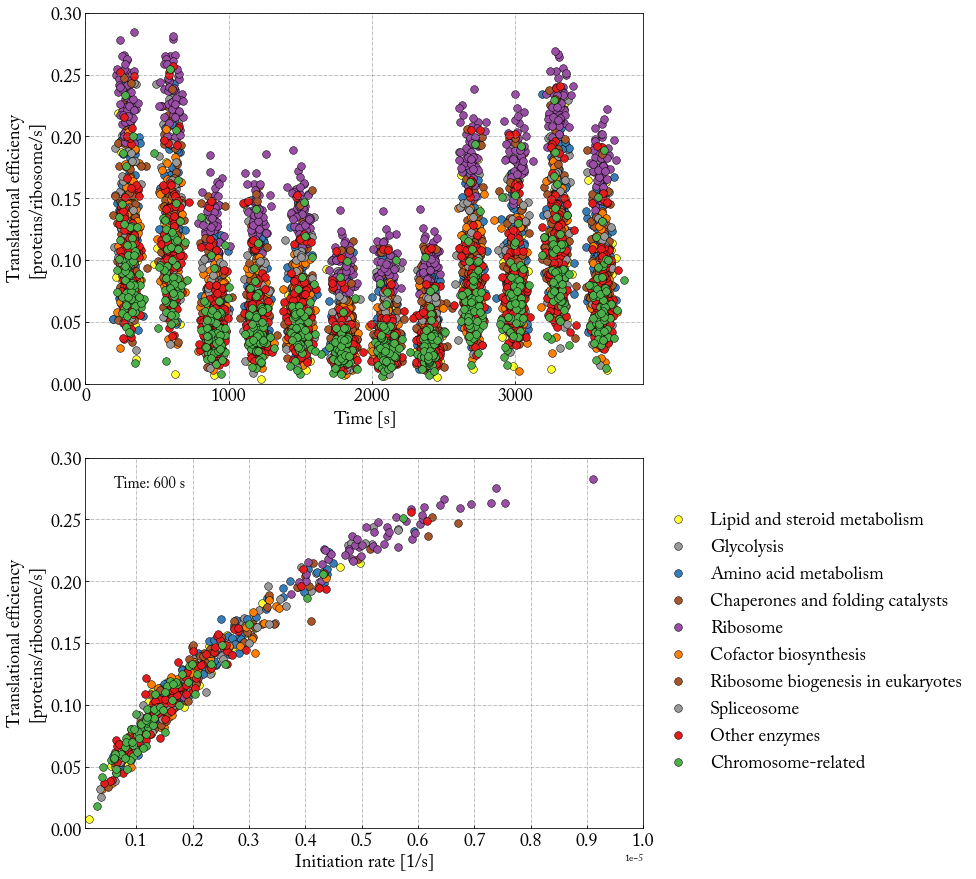

In [26]:
plt.rcParams['figure.figsize'] = (10, 15)

fig =  plt.figure()                

ax = fig.add_subplot(211, axisbg='white')

fontsize = 18
markersize = 60

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function in functional_categories.keys():
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function, s=markersize, edgecolor='black',
                     rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

shortlabels = list(set(labels))

#plt.text(-350, 0.3, "A", fontsize=24, weight="bold")

ax = fig.add_subplot(212, axisbg='white')

time = 300
#fontsize = 24
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function in functional_categories.keys():
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                       label=function, s=markersize, edgecolor='black', rasterized=True)
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 600 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('time_and_init_rate_resolved_efficiency.png', bbox_inches='tight', dpi=400)
#plt.show()

#### Separate plots

Trick to make labels unique: https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib

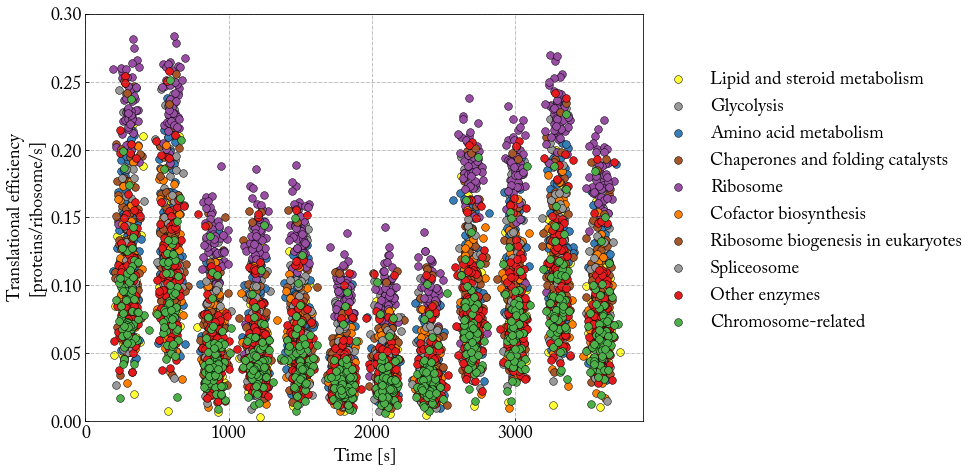

In [27]:
plt.rcParams['figure.figsize'] = (10, 7.5)

fig =  plt.figure()                

ax = fig.add_subplot(111, axisbg='white')

fontsize = 18
markersize = 60

xaxislabel = 'Time [s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
plt.xlim([0, 3900])
plt.ylim([0.0, 0.3])
#plt.locator_params(axis='x',nbins=10)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

for function in functional_categories.keys():
    df = time_tes_annotated[time_tes_annotated['Function']==function]
    del df['Function']
    df = df[df!=0]  # not sure why but after updating there were many zero values. I remove them manually
    df = df.transpose()
    for i, gene in enumerate(df.columns):
        scat = jitter(df.index+300, df[gene], c=colordict[function], label=function if i == 0 else "", 
                      s=markersize, edgecolor='black', rasterized=True)
        scat.set_alpha(1.0)      

handles, labels = ax.get_legend_handles_labels()
#print handles
#print labels

#labels = list(set(labels))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')


#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('time_resolved_efficiency.png', bbox_inches='tight', dpi=400)
#plt.show()

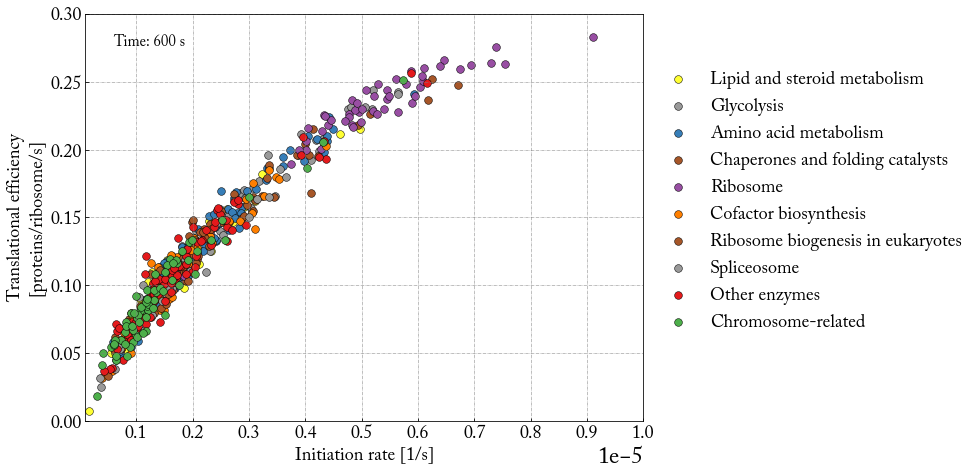

In [28]:
plt.rcParams['figure.figsize'] = (10, 7.5)

fig =  plt.figure()                

ax = fig.add_subplot(111, axisbg='white')

fontsize = 18
markersize = 60

time = 300
#fontsize = 24
xaxislabel = 'Initiation rate [1/s]'
yaxislabel = 'Translational efficiency\n[proteins/ribosome/s]'

ax.grid(True, linestyle = '-.', color = 'grey')

for function in functional_categories.keys():
    scat = plt.scatter(init_rates_by_function[function], time_tes_by_function[time][function], c=colordict[function], 
                       label=function, s=markersize, edgecolor='black', rasterized=True)
    scat.set_alpha(1.0)
    
#plt.title('Time: {} s'.format(time+300), loc='left', fontsize=fontsize)
ax.text(.05, .92, 'Time: 600 s', horizontalalignment='left', transform=ax.transAxes, fontsize=15)

plt.xlim([1e-7, 1.0e-5])
plt.ylim([0.0, 0.3])
plt.locator_params(axis='x',nbins=10)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), fontsize=fontsize)
plt.rc('font', **{'size':'24'})

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fontsize)
legend = plt.legend(fancybox=True, fontsize=fontsize, bbox_to_anchor=(1.0, 0.9), frameon=False)
legend.get_frame().set_facecolor('white')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(xaxislabel)
ax.set_xlabel(xaxislabel, fontsize=fontsize)
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
ax.set_ylabel(yaxislabel)
ax.set_ylabel(yaxislabel, fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)

#plt.text(-0.08e-5, 0.3, "B", fontsize=24, weight="bold")

plt.savefig('efficiency_by_function_and_init_rate.png', bbox_inches='tight', dpi=400)
#plt.show()

In [29]:
time_tes_by_function.keys()

[0, 2400, 900, 1800, 2700, 300, 1200, 3000, 2100, 600, 3300, 1500]

In [30]:
time_tes_by_function[0].keys()

['Lipid and steroid metabolism',
 'Glycolysis',
 'Chaperones and folding catalysts',
 'Ribosome',
 'Cofactor biosynthesis',
 'Ribosome biogenesis in eukaryotes',
 'Amino acid metabolism',
 'Spliceosome',
 'Other enzymes',
 'Chromosome-related']

In [31]:
pkl.dump(time_tes_by_function, open("../../parameters/time_tes_by_function.p", "wb"))

In [32]:
pkl.dump(all_time_tes_annotated, open("../../parameters/all_time_tes_annotated.df", "wb"))

In [33]:
all_time_tes_annotated

,0,300,600,900,1200,1500,1800,2100,2400,2700,3000,3300,Function
YBR177C,0.128333,0.133333,NaN,0.043333,0.055833,0.034167,0.031000,0.037500,0.091667,0.077500,0.123333,0.065000,
YIL140W,0.098333,0.100000,0.040833,0.048333,0.048333,0.031667,NaN,NaN,0.078333,NaN,NaN,NaN,
YLR268W,0.135000,0.110000,0.060333,0.054048,0.055333,0.036458,0.036970,0.034167,0.088333,0.080556,0.120000,0.072222,SNARE interactions in vesicular transport
YJL155C,0.115000,NaN,0.038333,0.053333,0.043333,0.035000,0.025833,0.020000,0.078333,0.080000,0.100000,0.075000,Carbohydrate metabolism
YLR197W,0.143333,0.145000,0.071322,0.069624,0.075333,0.048251,0.048145,0.050645,0.105000,0.108512,0.139792,0.102849,Ribosome biogenesis in eukaryotes
YAL008W,0.141667,0.158333,0.082917,0.083889,0.081667,0.062917,0.054167,0.069167,0.108333,0.128333,0.153333,NaN,
YBR255W,NaN,0.063333,0.012500,0.025000,0.024167,0.018333,0.014167,0.016111,0.040000,0.048333,0.056667,0.040833,
YJL122W,0.144444,0.147778,0.076481,0.079028,0.077778,0.051556,0.050079,0.052179,0.111111,0.108056,0.142000,0.106852,
YIL034C,0.107500,0.113333,0.049583,0.053056,0.055333,0.034074,0.033810,0.038333,0.075000,0.074583,0.114444,0.071111,
YML006C,0.046667,0.068333,0.023333,0.024167,0.034167,0.019167,0.015000,0.018333,NaN,0.041667,NaN,0.040000,


In [37]:
functional_counts = all_time_tes_annotated.Function.value_counts(dropna=False)

In [38]:
functional_counts[functional_counts >= 50].index.drop(u'')

Index([u'Other enzymes', u'Amino acid metabolism', u'Chromosome-related',
       u'Ribosome', u'Cofactor biosynthesis', u'Lipid and steroid metabolism',
       u'Chaperones and folding catalysts',
       u'Ribosome biogenesis in eukaryotes', u'Glycolysis', u'Spliceosome'],
      dtype='object')

In [45]:
all_time_tes_annotated[all_time_tes_annotated.Function.isin(functional_counts[functional_counts >= 50]
                .index.drop(u''))].groupby(['Function']).size().reset_index(name='counts').sort_values('counts', ascending=False)

,Function,counts
6,Other enzymes,122
0,Amino acid metabolism,116
2,Chromosome-related,112
7,Ribosome,110
3,Cofactor biosynthesis,82
5,Lipid and steroid metabolism,66
1,Chaperones and folding catalysts,63
8,Ribosome biogenesis in eukaryotes,55
4,Glycolysis,53
9,Spliceosome,52
